In [133]:
import numpy as np
import pandas as pd
from plotnine import *
import multiprocessing as mp
import itertools
import random
from scipy.interpolate import interp1d
class LangevinCellCycle:
    def __init__(self, rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
    replication_time, division_time):
        self.kg = rxn_rates[0]
        self.gamma_g = rxn_rates[1]
        self.km = rxn_rates[2]
        self.gamma_m = rxn_rates[3]
        self.kp = rxn_rates[3]
        self.gamma_p = rxn_rates[4]
        self.time_step = time_step
        self.gene_copy = gene_copy
        self.dosage_compensation_factor = dosage_compensation_factor
        self.delta_m = None
        self.var_delta_m = None
        self.replication_time = replication_time
        self.division_time = division_time
        self.production_accumulated = 0
        self.accumulation_flag = 0
        

    def CLEComputeMeanVar(self):
        bm = self.km / (self.kg + self.gamma_g)
        self.delta_m = self.gene_copy * self.kg * self.time_step * bm
        self.var_delta_m = self.gene_copy * self.kg * self.time_step * bm * \
        (2 * bm + 1)
    
    def sample_time_step(self):
        bm = self.km / (self.kg + self.gamma_g)
        a0 = self.gene_copy * self.kg * bm
        r1 = np.random.uniform()
        self.time_step = -np.log(r1)/a0

    def update_molecule_count(self, molecule_count_cur):
        molecule_count = [None] * len(molecule_count_cur)
        for _ in range(len(molecule_count_cur)):
            molecule_count[_] = molecule_count_cur[_]
        brownian_noise = np.random.normal(size = 4)
        
        production = self.delta_m + \
        np.sqrt(self.var_delta_m) * brownian_noise[0]
        if self.accumulation_flag:
            self.production_accumulated += production
            if self.production_accumulated > 0:
                molecule_count[0] += self.production_accumulated - \
                self.gamma_m * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]
                self.accumulation_flag = 0
                self.production_accumulated = 0
            else:
                molecule_count[0] += - \
                self.gamma_m * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]
        else:
            if production > 0:
                molecule_count[0] += production - \
                self.gamma_m * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]
            else:
                self.accumulation_flag = 1
                self.production_accumulated = production
                molecule_count[0] += - \
                self.gamma_m * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]
                
#         molecule_count[0] += self.delta_m + \
#         np.sqrt(self.var_delta_m) * brownian_noise[0] - \
#         self.gamma_m * molecule_count_cur[0] * time_step - \
#         np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]

        molecule_count[1] += self.kp * molecule_count_cur[0] * self.time_step + \
        np.sqrt(self.kp * molecule_count_cur[0] * self.time_step) * brownian_noise[2] - \
        self.gamma_p * molecule_count_cur[1] * time_step - \
        np.sqrt(self.gamma_p * molecule_count_cur[1] * time_step) * brownian_noise[3]

        return molecule_count

    def simulate(self, time_, molecule_count):
        time_list = [0]
        molecule_count_cur = [None] * 2
        cycle_num = 0
        while sum(time_list) < time_:
#             print('Time = ' + str(self.accumulation_flag))
#             self.sample_time_step()
            if ((sum(time_list) + self.time_step < \
            cycle_num * self.division_time + self.replication_time and \
            sum(time_list) >= cycle_num * self.division_time) or \
            (sum(time_list) + self.time_step < \
            (cycle_num + 1) * self.division_time and \
            sum(time_list) >= \
            cycle_num * self.division_time + self.replication_time)):
                for _ in range(2):
                    molecule_count_cur[_] = molecule_count[_][-1]
                if (sum(time_list) + self.time_step < \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) >= cycle_num * self.division_time):
                    self.gene_copy = 2
                else:
                    self.gene_copy = 4
                time_list.append(self.time_step)
                self.CLEComputeMeanVar()
                molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                for _ in range(2):
                        (molecule_count[_]).append(molecule_count_cur[_])
            else:
                if sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) + self.time_step > \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) < \
                cycle_num * self.division_time + self.replication_time:
                    self.kg *= self.dosage_compensation_factor
                    self.gene_copy = 4
                    for _ in range(2):
                        molecule_count_cur[_] = molecule_count[_][-1]
                    time_list.append(self.time_step)
                    self.CLEComputeMeanVar()
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                    for _ in range(2):
                            (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    self.kg /= self.dosage_compensation_factor
                    self.gene_copy = 2
                    for _ in range(2):
                        molecule_count_cur[_] = molecule_count[_][-1]
                    mRNA_n = molecule_count_cur[0]
                    mRNA_m = molecule_count_cur[1]
                    molecule_count_cur[0] = 0
                    molecule_count_cur[1] = 0
                    for _ in range(int(mRNA_n)):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[0] += 1
                    for _ in range(int(mRNA_m)):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[1] += 1
                    time_list.append(self.time_step)
                    self.CLEComputeMeanVar()
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                    for _ in range(2):
                            (molecule_count[_]).append(molecule_count_cur[_])
                    cycle_num += 1
        self.time_list = time_list
        self.molecule_count = molecule_count


In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import multiprocessing as mp
import itertools
import random
from scipy.interpolate import interp1d
class LangevinCellCycle:
    def __init__(self, rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
    replication_time, division_time):
        self.kg = rxn_rates[0]
        self.gamma_g = rxn_rates[1]
        self.km = rxn_rates[2]
        self.gamma_m = rxn_rates[3]
        self.kp = rxn_rates[3]
        self.gamma_p = rxn_rates[4]
        self.time_step = time_step
        self.gene_copy = gene_copy
        self.dosage_compensation_factor = dosage_compensation_factor
        self.delta_m = None
        self.var_delta_m = None
        self.replication_time = replication_time
        self.division_time = division_time
        self.production_accumulated = 0
        self.accumulation_flag = 0
        

    def CLEComputeMeanVar(self):
        bm = self.km / (self.kg + self.gamma_g)
        bp = self.kp / self.gamma_m
        self.delta_m = self.gene_copy * self.kg * self.time_step * bm * bp
        self.var_delta_m = self.gene_copy * self.kg * self.time_step * bm * bp * \
        (2 * bm * bp + 2 * bp + 1)
    
    def sample_time_step(self):
        bm = self.km / (self.kg + self.gamma_g)
        bp = self.kp / self.gamma_m
        a0 = self.gene_copy * self.kg * bm * bp
        r1 = np.random.uniform()
        self.time_step = -np.log(r1)/a0

    def update_molecule_count(self, molecule_count_cur):
        molecule_count = [None] * len(molecule_count_cur)
        for _ in range(len(molecule_count_cur)):
            molecule_count[_] = molecule_count_cur[_]
        brownian_noise = np.random.normal(size = 4)
        
        production = self.delta_m + \
        np.sqrt(self.var_delta_m) * brownian_noise[0]
        if self.accumulation_flag:
            self.production_accumulated += production
            if self.production_accumulated > 0:
                molecule_count[0] += self.production_accumulated - \
                self.gamma_p * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]
                self.accumulation_flag = 0
                self.production_accumulated = 0
            else:
                molecule_count[0] += - \
                self.gamma_p * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]
        else:
            if production > 0:
                molecule_count[0] += production - \
                self.gamma_p * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]
            else:
                self.accumulation_flag = 1
                self.production_accumulated = production
                molecule_count[0] += - \
                self.gamma_p * molecule_count_cur[0] * time_step - \
                np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]
                
#         molecule_count[0] += self.delta_m + \
#         np.sqrt(self.var_delta_m) * brownian_noise[0] - \
#         self.gamma_m * molecule_count_cur[0] * time_step - \
#         np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]

        molecule_count[1] += self.kp * molecule_count_cur[0] * self.time_step + \
        np.sqrt(self.kp * molecule_count_cur[0] * self.time_step) * brownian_noise[2] - \
        self.gamma_p * molecule_count_cur[1] * time_step - \
        np.sqrt(self.gamma_p * molecule_count_cur[1] * time_step) * brownian_noise[3]

        return molecule_count

    def simulate(self, time_, molecule_count):
        time_list = [0]
        molecule_count_cur = [None] * 2
        cycle_num = 0
        while sum(time_list) < time_:
#             print('Time = ' + str(self.accumulation_flag))
#             self.sample_time_step()
            if ((sum(time_list) + self.time_step < \
            cycle_num * self.division_time + self.replication_time and \
            sum(time_list) >= cycle_num * self.division_time) or \
            (sum(time_list) + self.time_step < \
            (cycle_num + 1) * self.division_time and \
            sum(time_list) >= \
            cycle_num * self.division_time + self.replication_time)):
                for _ in range(2):
                    molecule_count_cur[_] = molecule_count[_][-1]
                if (sum(time_list) + self.time_step < \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) >= cycle_num * self.division_time):
                    self.gene_copy = 2
                else:
                    self.gene_copy = 4
                time_list.append(self.time_step)
                self.CLEComputeMeanVar()
                molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                for _ in range(2):
                        (molecule_count[_]).append(molecule_count_cur[_])
            else:
                if sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) + self.time_step > \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) < \
                cycle_num * self.division_time + self.replication_time:
                    self.kg *= self.dosage_compensation_factor
                    self.gene_copy = 4
                    for _ in range(2):
                        molecule_count_cur[_] = molecule_count[_][-1]
                    time_list.append(self.time_step)
                    self.CLEComputeMeanVar()
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                    for _ in range(2):
                            (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    self.kg /= self.dosage_compensation_factor
                    self.gene_copy = 2
                    for _ in range(2):
                        molecule_count_cur[_] = molecule_count[_][-1]
                    mRNA_n = molecule_count_cur[0]
                    mRNA_m = molecule_count_cur[1]
                    molecule_count_cur[0] = 0
                    molecule_count_cur[1] = 0
                    for _ in range(int(mRNA_n)):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[0] += 1
                    for _ in range(int(mRNA_m)):
                        if np.random.randint(0, 2) == 1:
                            molecule_count_cur[1] += 1
                    time_list.append(self.time_step)
                    self.CLEComputeMeanVar()
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                    for _ in range(2):
                            (molecule_count[_]).append(molecule_count_cur[_])
                    cycle_num += 1
        self.time_list = time_list
        self.molecule_count = molecule_count

        
def LangevinCellCycleParallel(rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
                              replication_time, division_time, time_, molecule_count):
    class LangevinCellCycle:
        def __init__(self, rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
        replication_time, division_time):
            self.kg = rxn_rates[0]
            self.gamma_g = rxn_rates[1]
            self.km = rxn_rates[2]
            self.gamma_m = rxn_rates[3]
            self.kp = rxn_rates[3]
            self.gamma_p = rxn_rates[4]
            self.time_step = time_step
            self.gene_copy = gene_copy
            self.dosage_compensation_factor = dosage_compensation_factor
            self.delta_m = None
            self.var_delta_m = None
            self.replication_time = replication_time
            self.division_time = division_time
            self.production_accumulated = 0
            self.accumulation_flag = 0


        def CLEComputeMeanVar(self):
            bm = np.copy(self.km / (self.kg + self.gamma_g))
            bp = np.copy(self.kp / self.gamma_m)
            self.delta_m = np.copy(self.gene_copy) * np.copy(self.kg) * np.copy(self.time_step) * bm * bp
            self.var_delta_m = np.copy(self.gene_copy) * np.copy(self.kg) * np.copy(self.time_step) * bm * bp * \
            (2 * bm * bp + 2 * bp + 1)

        def sample_time_step(self):
            bm = np.copy(self.km / (self.kg + self.gamma_g))
            bp = np.copy(self.kp / self.gamma_m)
            a0 = np.copy(self.gene_copy * self.kg * bm * bp)
            r1 = np.random.uniform()
            self.time_step = -np.log(r1)/a0

        def update_molecule_count(self, molecule_count_cur):
            molecule_count = [None] * len(molecule_count_cur)
            for _ in range(len(molecule_count_cur)):
                molecule_count[_] = molecule_count_cur[_]
            brownian_noise = np.random.normal(size = 4)

            production = self.delta_m + \
            np.sqrt(self.var_delta_m) * brownian_noise[0]
            if self.accumulation_flag:
                self.production_accumulated += production
                if self.production_accumulated > 0:
                    molecule_count[0] += self.production_accumulated - \
                    self.gamma_p * molecule_count_cur[0] * time_step - \
                    np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]
                    self.accumulation_flag = 0
                    self.production_accumulated = 0
                else:
                    molecule_count[0] += - \
                    self.gamma_p * molecule_count_cur[0] * time_step - \
                    np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]
            else:
                if production > 0:
                    molecule_count[0] += production - \
                    self.gamma_p * molecule_count_cur[0] * time_step - \
                    np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]
                else:
                    self.accumulation_flag = 1
                    self.production_accumulated = production
                    molecule_count[0] += - \
                    self.gamma_p * molecule_count_cur[0] * time_step - \
                    np.sqrt(self.gamma_p * molecule_count_cur[0] * time_step) * brownian_noise[1]

    #         molecule_count[0] += self.delta_m + \
    #         np.sqrt(self.var_delta_m) * brownian_noise[0] - \
    #         self.gamma_m * molecule_count_cur[0] * time_step - \
    #         np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]

            molecule_count[1] += self.kp * molecule_count_cur[0] * self.time_step + \
            np.sqrt(self.kp * molecule_count_cur[0] * self.time_step) * brownian_noise[2] - \
            self.gamma_p * molecule_count_cur[1] * time_step - \
            np.sqrt(self.gamma_p * molecule_count_cur[1] * time_step) * brownian_noise[3]

            return molecule_count

        def simulate(self, time_, molecule_count):
            time_list = [0]
            molecule_count_cur = [None] * 2
            cycle_num = 0
            while sum(time_list) < time_:
    #             print('Time = ' + str(self.accumulation_flag))
    #             self.sample_time_step()
                if ((sum(time_list) + self.time_step < \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) >= cycle_num * self.division_time) or \
                (sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) >= \
                cycle_num * self.division_time + self.replication_time)):
                    for _ in range(2):
                        molecule_count_cur[_] = molecule_count[_][-1]
                    if (sum(time_list) + self.time_step < \
                    cycle_num * self.division_time + self.replication_time and \
                    sum(time_list) >= cycle_num * self.division_time):
                        self.gene_copy = 2
                    else:
                        self.gene_copy = 4
                    time_list.append(self.time_step)
                    self.CLEComputeMeanVar()
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                    for _ in range(2):
                            (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    if sum(time_list) + self.time_step < \
                    (cycle_num + 1) * self.division_time and \
                    sum(time_list) + self.time_step > \
                    cycle_num * self.division_time + self.replication_time and \
                    sum(time_list) < \
                    cycle_num * self.division_time + self.replication_time:
                        self.kg *= self.dosage_compensation_factor
                        self.gene_copy = 4
                        for _ in range(2):
                            molecule_count_cur[_] = molecule_count[_][-1]
                        time_list.append(self.time_step)
                        self.CLEComputeMeanVar()
                        molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                        for _ in range(2):
                                (molecule_count[_]).append(molecule_count_cur[_])
                    else:
                        self.kg /= self.dosage_compensation_factor
                        self.gene_copy = 2
                        for _ in range(2):
                            molecule_count_cur[_] = molecule_count[_][-1]
                        mRNA_n = molecule_count_cur[0]
                        mRNA_m = molecule_count_cur[1]
                        molecule_count_cur[0] = 0
                        molecule_count_cur[1] = 0
                        for _ in range(int(mRNA_n)):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[0] += 1
                        for _ in range(int(mRNA_m)):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[1] += 1
                        time_list.append(self.time_step)
                        self.CLEComputeMeanVar()
                        molecule_count_cur = self.update_molecule_count(molecule_count_cur)
                        for _ in range(2):
                                (molecule_count[_]).append(molecule_count_cur[_])
                        cycle_num += 1
            self.time_list = time_list
            self.molecule_count = molecule_count
    two_state = LangevinCellCycle(rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
                                  replication_time, division_time)
    two_state.simulate(time_, molecule_count)
    return two_state.time_list, two_state.molecule_count[0]


In [150]:
rxn_rates = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
time_step = 0.323
time_ = 5000
tr = 400
td = 780
gene_copy = 2
dosage_compensation_factor = 0.71
two_state = LangevinCellCycle(rxn_rates, time_step, 2, dosage_compensation_factor, \
    tr, td)

In [151]:
molecule_count = [[5], [10]]
two_state.simulate(time_, molecule_count)

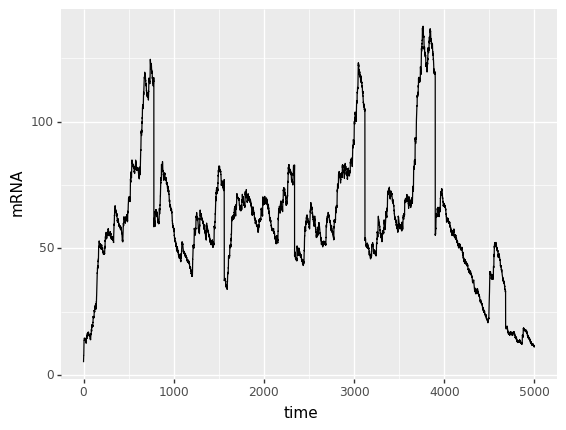

<ggplot: (8729390725110)>


In [152]:
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[0]}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line()
print(p)

In [6]:
rxn_rates = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
time_step = 0.163
time_ = 5000
tr = 400
td = 780
gene_copy = 2
dosage_compensation_factor = 0.71
molecule_count = [[10], [10]]
numCores = 10
nrepeats = 1000
pool = mp.Pool(numCores)
results = []
res = [pool.apply_async(LangevinCellCycleParallel, \
            args=(rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
                 tr, td, time_, molecule_count))\
       for i in range(nrepeats)]
results = [r.get() for r in res]
pool.close()

In [7]:
xnew = np.linspace(0, 5000, num=1000, endpoint=True)
ynew = np.zeros((1000))
for _ in range(nrepeats):
    x = np.cumsum(results[_][0])
    y = results[_][1]
    func_ = interp1d(x, y, kind='linear')
    ynew += func_(xnew)
ynew /= nrepeats

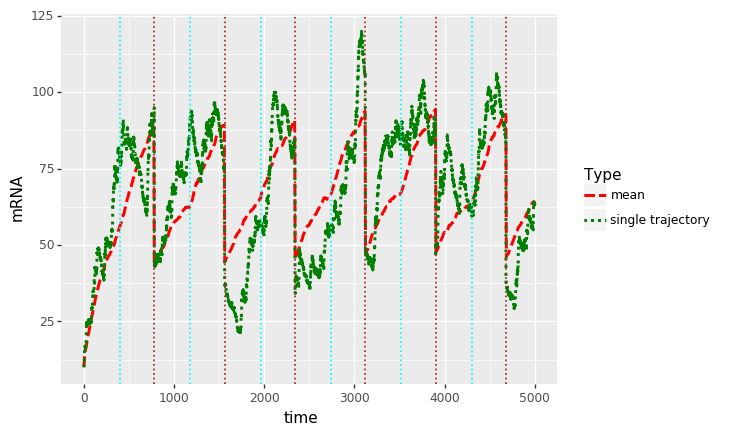

<ggplot: (8728393204088)>


In [12]:
i = 87
j = 1
data = {'time': (np.cumsum(results[i][0])).tolist() + \
        (xnew).tolist(), \
       'mRNA': results[i][1] + \
       (ynew).tolist(), 
       'Type': (['single trajectory'] * len(results[i][0])) + (['mean'] * len(ynew))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='mRNA')) + geom_line(aes(linetype='Type', color='Type'), size = 1.2) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
time_cur = tr
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "cyan", size = 0.7)
    time_cur += td
time_cur = td
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "brown", size = 0.7)
    time_cur += td
    
print(p)

In [40]:
def TranscriptionRateStochastic(kr0, alpha_, beta_, division_time, time_, time_step):
    time_list = [0]
    kr_list = [kr0]
    cycle_num = 0
    while sum(time_list) < time_:
#         print('Time = ' + str(sum(time_list)) + ' kr = ' + str(kr_list[-1]))
        if sum(time_list) + time_step < \
        (cycle_num + 1) * division_time and \
        sum(time_list) >= \
        cycle_num * division_time:
            kr_cur[0] = kr_list[-1]
            brownian_noise = np.random.normal(size = 1)
            kr_cur[0] += 0 * alpha_ * kr_cur[0] * time_step + \
            beta_ * np.sqrt(alpha_ * kr_cur[0] * time_step) * brownian_noise
            kr_list.append(kr_cur[0])
            time_list.append(time_step)
        elif sum(time_list) + time_step >= \
        (cycle_num + 1) * division_time and \
        sum(time_list) < \
        (cycle_num + 1) * division_time:
            kr_cur[0] = kr_list[-1]
            brownian_noise = np.random.normal(size = 1)
            time_step_cur = time_step - ((cycle_num + 1) * division_time - sum(time_list))
            kr_cur[0] += 0 * alpha_ * kr_cur[0] * time_step_cur + \
            beta_ * np.sqrt(alpha_ * kr_cur[0] * time_step_cur) * brownian_noise
            kr_list.append(kr_cur[0])
            time_list.append(time_step)
            cycle_num += 1
    return kr_list, time_list

def TranscriptionRateStochastic(kr0, alpha_, beta_, division_time, time_, time_step):
    time_list = [0]
    kr_list = [kr0]
    cycle_num = 0
    kr_cur = [0]
    while sum(time_list) < time_:
#         print('Time = ' + str(sum(time_list)) + ' kr = ' + str(kr_list[-1]))
        if sum(time_list) + time_step < \
        (cycle_num + 1) * division_time and \
        sum(time_list) >= \
        cycle_num * division_time:
            kr_cur[0] = kr_list[-1]
            brownian_noise = np.random.normal(size = 1)
            kr_cur[0] += 0 * alpha_ * kr_cur[0] * time_step + \
            beta_ * np.sqrt(alpha_ * time_step) * brownian_noise
            kr_list.append(kr_cur[0][0])
            time_list.append(time_step)
        elif sum(time_list) + time_step >= \
        (cycle_num + 1) * division_time and \
        sum(time_list) < \
        (cycle_num + 1) * division_time:
            kr_cur[0] = kr_list[-1]
            brownian_noise = np.random.normal(size = 1)
            time_step_cur = time_step - ((cycle_num + 1) * division_time - sum(time_list))
            kr_cur[0] += 0 * alpha_ * kr_cur[0] * time_step_cur + \
            beta_ * np.sqrt(alpha_ * time_step_cur) * brownian_noise
            kr_list.append(kr_cur[0][0])
            time_list.append(time_step)
            cycle_num += 1
    return kr_list, time_list

In [41]:
kr0 = 2.11
alpha_ = 0.001
beta_ = 1
division_time = 780
time_ = 5000
time_step = 0.323
kr_list, time_list = TranscriptionRateStochastic(kr0, alpha_, beta_, division_time, time_, time_step)

In [42]:
kr_cur = [0]
kr_cur.append(kr_cur[-1])
print(np.array(kr_cur[1]))

0


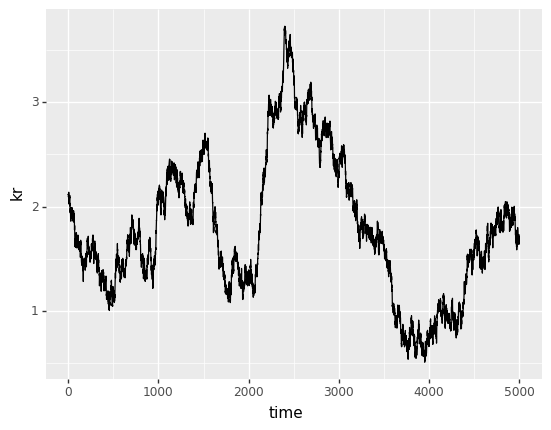

<ggplot: (8728276611069)>


In [43]:
data = {'time': (np.cumsum(time_list)).tolist(), 'kr': kr_list}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='kr')) + geom_line()
print(p)

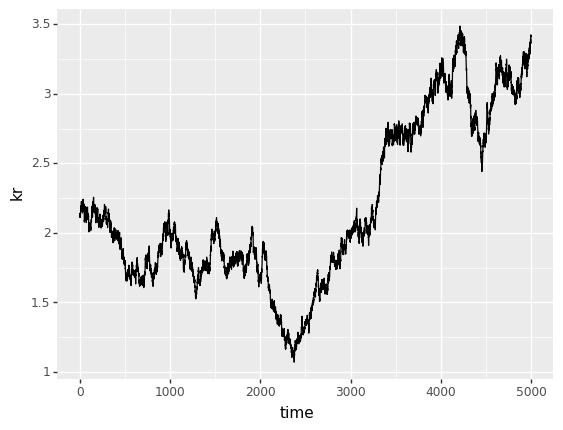

<ggplot: (-9223363307274145350)>


In [230]:
data = {'time': (np.cumsum(time_list)).tolist(), 'kr': kr_list}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='kr')) + geom_line()
print(p)

In [186]:
brownian_noise = np.random.normal(size = 1)
kr_cur = kr0
kr_cur += alpha_ * kr_cur * time_step + beta_ * np.sqrt(alpha_ * kr_cur * time_step) * brownian_noise
print(kr_cur)

[2.1658078]


In [221]:
print(np.random.normal(size = 1))

[-0.22368347]


In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import multiprocessing as mp
import itertools
import random
from scipy.interpolate import interp1d        
def LangevinCellCycleParallel(rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
                              replication_time, division_time, time_, molecule_count, alpha_):
    class LangevinCellCycle:
        def __init__(self, rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
        replication_time, division_time, alpha_):
            self.kg = rxn_rates[0]
            self.gamma_g = rxn_rates[1]
            self.km = rxn_rates[2]
            self.gamma_m = rxn_rates[3]
            self.kp = rxn_rates[3]
            self.gamma_p = rxn_rates[4]
            self.time_step = time_step
            self.gene_copy = gene_copy
            self.dosage_compensation_factor = dosage_compensation_factor
            self.delta_m = None
            self.var_delta_m = None
            self.replication_time = replication_time
            self.division_time = division_time
            self.production_accumulated = 0
            self.accumulation_flag = 0
            self.param_list = {}


#         def CLEComputeMeanVar(self):
#             bm = np.copy(self.km / (self.kg + self.gamma_g))
#             bp = np.copy(self.kp / self.gamma_m)
#             self.delta_m = np.copy(self.gene_copy) * np.copy(self.kg) * np.copy(self.time_step) * bm * bp
#             self.var_delta_m = np.copy(self.gene_copy) * np.copy(self.kg) * np.copy(self.time_step) * bm * bp * \
#             (2 * bm * bp + 2 * bp + 1)
        
        def CLEComputeMeanVar(self, param_list):
            bm = np.copy(param_list['km'] / (param_list['kg'] + param_list['gamma_g']))
            bp = np.copy(param_list['kp'] / param_list['gamma_m'])
            self.delta_m = np.copy(self.gene_copy) * np.copy(param_list['kg']) * \
            np.copy(self.time_step) * bm * bp
            self.var_delta_m = np.copy(self.gene_copy) * np.copy(param_list['kg']) * \
            np.copy(self.time_step) * bm * bp * \
            (2 * bm * bp + 2 * bp + 1)

#         def sample_time_step(self):
#             bm = np.copy(self.km / (self.kg + self.gamma_g))
#             bp = np.copy(self.kp / self.gamma_m)
#             a0 = np.copy(self.gene_copy * self.kg * bm * bp)
#             r1 = np.random.uniform()
#             self.time_step = -np.log(r1)/a0
            
        def sample_time_step(self, param_list):
            bm = np.copy(param_list['km'] / (param_list['kg'] + param_list['gamma_g']))
            bp = np.copy(param_list['kp'] / param_list['gamma_m'])
            a0 = np.copy(self.gene_copy * param_list['kg'] * bm * bp)
            r1 = np.random.uniform()
            self.time_step = -np.log(r1)/a0

        def update_molecule_count(self, molecule_count_cur, param_list):
            molecule_count = [None] * len(molecule_count_cur)
            for _ in range(len(molecule_count_cur)):
                molecule_count[_] = molecule_count_cur[_]
            brownian_noise = np.random.normal(size = 4)

            production = self.delta_m + \
            np.sqrt(self.var_delta_m) * brownian_noise[0]
            if self.accumulation_flag:
                self.production_accumulated += production
                if self.production_accumulated > 0:
                    molecule_count[0] += self.production_accumulated - \
                    param_list['gamma_p'] * molecule_count_cur[0] * self.time_step - \
                    np.sqrt(param_list['gamma_p'] * molecule_count_cur[0] * self.time_step) * brownian_noise[1]
                    self.accumulation_flag = 0
                    self.production_accumulated = 0
                else:
                    molecule_count[0] += - \
                    param_list['gamma_p'] * molecule_count_cur[0] * self.time_step - \
                    np.sqrt(param_list['gamma_p'] * molecule_count_cur[0] * self.time_step) * brownian_noise[1]
            else:
                if production > 0:
                    molecule_count[0] += production - \
                    param_list['gamma_p'] * molecule_count_cur[0] * self.time_step - \
                    np.sqrt(param_list['gamma_p'] * molecule_count_cur[0] * self.time_step) * brownian_noise[1]
                else:
                    self.accumulation_flag = 1
                    self.production_accumulated = production
                    molecule_count[0] += - \
                    param_list['gamma_p'] * molecule_count_cur[0] * self.time_step - \
                    np.sqrt(param_list['gamma_p'] * molecule_count_cur[0] * self.time_step) * brownian_noise[1]

    #         molecule_count[0] += self.delta_m + \
    #         np.sqrt(self.var_delta_m) * brownian_noise[0] - \
    #         self.gamma_m * molecule_count_cur[0] * time_step - \
    #         np.sqrt(self.gamma_m * molecule_count_cur[0] * time_step) * brownian_noise[1]

            molecule_count[1] += param_list['kp'] * molecule_count_cur[0] * self.time_step + \
            np.sqrt(param_list['kp'] * molecule_count_cur[0] * self.time_step) * brownian_noise[2] - \
            param_list['gamma_p'] * molecule_count_cur[1] * time_step - \
            np.sqrt(param_list['gamma_p'] * molecule_count_cur[1] * time_step) * brownian_noise[3]

            return molecule_count

        def simulate(self, time_, molecule_count):
            param_name = ['kg', 'gamma_g', \
                          'km', 'gamma_m', \
                          'kp', 'gamma_p']
            param_list = {'kg':[np.copy(self.kg)], 'gamma_g':[np.copy(self.gamma_g)], \
                          'km':[np.copy(self.km)], 'gamma_m':[np.copy(self.gamma_m)], \
                          'kp':[np.copy(self.kp)], 'gamma_p':[np.copy(self.gamma_p)]}
            time_list = [0]
            molecule_count_cur = [None] * 2
            cycle_num = 0
            while sum(time_list) < time_:
    #             print('Time = ' + str(self.accumulation_flag))
    #             self.sample_time_step()
                param_list_cur = {}
                for _ in range(len(param_name)):
                    param_list_cur[param_name[_]] = np.copy(param_list[param_name[_]][-1])
                    brownian_noise = np.random.normal(size = 1)
#                     print(param_name[_] + ' ' + str(param_list_cur[param_name[_]]))
#                     print(type(param_list_cur[param_name[_]]))
                    param_list_cur[param_name[_]] += 1 * \
                    np.sqrt(alpha_[_] * self.time_step) * brownian_noise[0]
                    (param_list[param_name[_]]).append(param_list_cur[param_name[_]])
#                 print(str(param_list['km'][-1]) + ' Molecule = ' + str(molecule_count_cur[0]))
                
                if ((sum(time_list) + self.time_step < \
                cycle_num * self.division_time + self.replication_time and \
                sum(time_list) >= cycle_num * self.division_time) or \
                (sum(time_list) + self.time_step < \
                (cycle_num + 1) * self.division_time and \
                sum(time_list) >= \
                cycle_num * self.division_time + self.replication_time)):
                    for _ in range(2):
                        molecule_count_cur[_] = molecule_count[_][-1]
                    if (sum(time_list) + self.time_step < \
                    cycle_num * self.division_time + self.replication_time and \
                    sum(time_list) >= cycle_num * self.division_time):
                        self.gene_copy = 2
                    else:
                        self.gene_copy = 4
                    time_list.append(self.time_step)
                    self.CLEComputeMeanVar(param_list_cur)
                    molecule_count_cur = self.update_molecule_count(molecule_count_cur, param_list_cur)
                    for _ in range(2):
                            (molecule_count[_]).append(molecule_count_cur[_])
                else:
                    if sum(time_list) + self.time_step < \
                    (cycle_num + 1) * self.division_time and \
                    sum(time_list) + self.time_step > \
                    cycle_num * self.division_time + self.replication_time and \
                    sum(time_list) < \
                    cycle_num * self.division_time + self.replication_time:
#                         self.kg *= self.dosage_compensation_factor
                        param_list_cur['kg'] *= np.copy(self.dosage_compensation_factor)
                        param_list['kg'][-1] *= np.copy(self.dosage_compensation_factor)
                        self.gene_copy = 4
                        for _ in range(2):
                            molecule_count_cur[_] = molecule_count[_][-1]
                        time_list.append(self.time_step)
                        self.CLEComputeMeanVar(param_list_cur)
                        molecule_count_cur = self.update_molecule_count(molecule_count_cur, param_list_cur)
                        for _ in range(2):
                                (molecule_count[_]).append(molecule_count_cur[_])
                    else:
#                         self.kg /= self.dosage_compensation_factor
                        param_list_cur['kg'] /= np.copy(self.dosage_compensation_factor)
                        param_list['kg'][-1] /= np.copy(self.dosage_compensation_factor)
                        self.gene_copy = 2
                        for _ in range(2):
                            molecule_count_cur[_] = molecule_count[_][-1]
                        mRNA_n = molecule_count_cur[0]
                        mRNA_m = molecule_count_cur[1]
                        molecule_count_cur[0] = 0
                        molecule_count_cur[1] = 0
                        for _ in range(int(mRNA_n)):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[0] += 1
                        for _ in range(int(mRNA_m)):
                            if np.random.randint(0, 2) == 1:
                                molecule_count_cur[1] += 1
                        time_list.append(self.time_step)
                        self.CLEComputeMeanVar(param_list_cur)
                        molecule_count_cur = self.update_molecule_count(molecule_count_cur, param_list_cur)
                        for _ in range(2):
                                (molecule_count[_]).append(molecule_count_cur[_])
                        cycle_num += 1
            self.time_list = time_list
            self.molecule_count = molecule_count
            self.param_list = param_list
#             print(str(self.param_list['km'][:10]) + ' Molecule = ' + str(molecule_count_cur[0]))
#             print(str(param_list['km'][-100]) + ' Molecule = ' + str(molecule_count_cur[0]))
    two_state = LangevinCellCycle(rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
                                  replication_time, division_time, alpha_)
    two_state.simulate(time_, molecule_count)
    return two_state.time_list, two_state.molecule_count[0], two_state.param_list


In [2]:
rxn_rates = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
alpha_ = [0.0000000, 0.0000, 0.0001, 0.00000, 0.00000, 0.000000000000]
time_step = 0.163
time_ = 5000
tr = 400
td = 780
gene_copy = 2
dosage_compensation_factor = 0.71
molecule_count = [[10], [10]]
numCores = 10
nrepeats = 100
pool = mp.Pool(numCores)
results = []
res = [pool.apply_async(LangevinCellCycleParallel, \
            args=(rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
                 tr, td, time_, molecule_count, alpha_))\
       for i in range(nrepeats)]
results = [r.get() for r in res]
pool.close()

In [84]:
rxn_rates = [0.0282, 0.609, 2.11, 0.1299, 0.00245]
alpha_ = [0.0000000, 0.0000, 0.0001, 0.00000, 0.00000, 0.000000000000]
time_step = 0.163
time_ = 5000
tr = 400
td = 780
gene_copy = 2
dosage_compensation_factor = 0.71
molecule_count = [[10], [10]]
time_list, molecule_count_list, param_list = \
LangevinCellCycleParallel(rxn_rates, time_step, gene_copy, dosage_compensation_factor, \
                 tr, td, time_, molecule_count, alpha_)

[array(2.11), array(2.10261397), array(2.10396326), array(2.09678916), array(2.09558367), array(2.09651016), array(2.09874261), array(2.10237378), array(2.09952066), array(2.09646646)] Molecule = 63.6363983542067


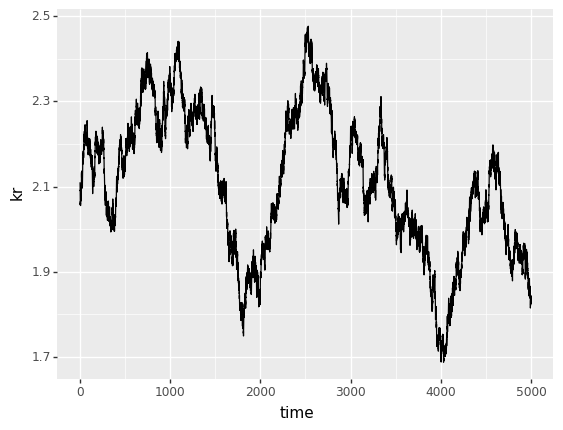

<ggplot: (8754547425442)>


In [85]:
data = {'time': (np.cumsum(time_list)).tolist(), 'kr': (np.array(param_list['km'])).tolist()}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='kr')) + geom_line()
print(p)

In [10]:
xnew = np.linspace(0, 5000, num=1000, endpoint=True)
ynew = np.zeros((1000))
for _ in range(nrepeats):
    x = np.cumsum(results[_][0])
    y = (np.array(results[_][2]['km'])).flatten()
    func_ = interp1d(x, y, kind='linear')
    ynew += func_(xnew)
ynew /= nrepeats

In [11]:
# print(param_list['km'][:10])

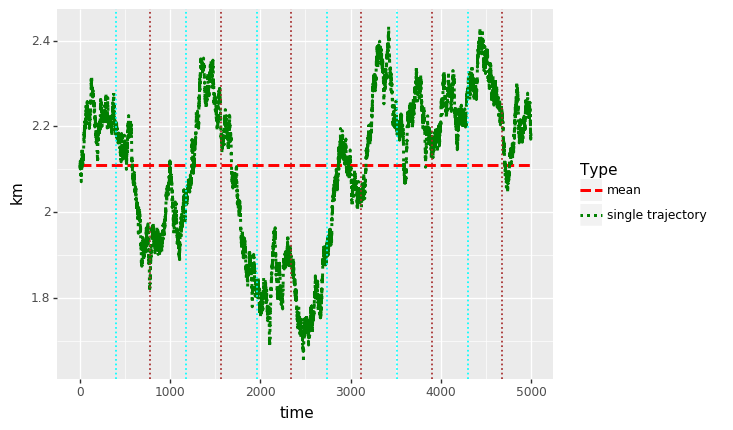

<ggplot: (8762641803710)>


In [13]:
i = 10
j = 1
data = {'time': (np.cumsum(results[i][0])).tolist() + \
        (xnew).tolist(), \
       'km': ((np.array(results[i][2]['km'])).flatten()).tolist() + \
       (ynew).tolist(), 
       'Type': (['single trajectory'] * len(results[i][0])) + (['mean'] * len(ynew))}
data = {'time': (np.cumsum(results[i][0])).tolist() + \
        (xnew).tolist(), \
       'km': ((np.array(results[i][2]['km'])).flatten()).tolist() + \
       (rxn_rates[2]*np.ones((1000))).tolist(), 
       'Type': (['single trajectory'] * len(results[i][0])) + (['mean'] * len(ynew))}
data = pd.DataFrame(data)
p = ggplot(data, aes(x='time', y='km')) + geom_line(aes(linetype='Type', color='Type'), size = 1.2) + \
scale_linetype_manual(values=["--", "dotted"])+ \
scale_color_manual(values=['red','green'])
time_cur = tr
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "cyan", size = 0.7)
    time_cur += td
time_cur = td
while time_cur <= 5000:
    p = p + geom_vline(xintercept = time_cur, linetype = "dotted", color = "brown", size = 0.7)
    time_cur += td
    
print(p)